# Introduction to the PostgreSQL event trigger

A regular trigger fires whenever an `INSERT`, `UPDATE`, `DELETE`, or `TRUNCATE` event occurs on an associated table.

To automatically respond to events related to data definition language (`DDL`) statements, you can use an event trigger.

An event trigger is a trigger that fires whenever an associated event occurs in the database.

PostgreSQL supports the following events:
* ddl_command_start
* ddl_command_end
* table_rewrite
* sql_drop

The `ddl_command_start` events before PostgreSQL executes the `CREATE`, `ALTER`, `DROP`, `GRANT`, `REVOKE`, `SECURITY LABEL`, and `COMMENT` statements. 

For additional information, see the overview of event trigger behavior: https://www.postgresql.org/docs/current/event-trigger-definition.html

Please note that the `ddl_command_start` does not occur for shared objects like databases, tablespaces, and roles.

The `ddl_command_end` occurs after the execution of the above DDL statements.

The `sql_drop` event occurs whenever you drop a database object, just before the `ddl_command_end` event.

The `table_rewrite` event occurs before you rewrite a table using the `ALTER TABLE` or `ALTER TYPE` statement.

---

**First, define a function that will execute when the event trigger fires:**

```postgresql
CREATE OR REPLACE FUNCTION event_trigger_function_name()
RETURNS EVENT_TRIGGER
AS
$$
BEGIN
   -- trigger logic
   -- ...
   -- no RETURN statement
END;
$$; 
```

The event trigger function returns `EVENT_TRIGGER` instead of `TRIGGER`. 

Additionally, it does not have any `RETURN` statement like a regular trigger function.

**Second, create an event trigger using the `CREATE EVENT TRIGGER` statement:**

```postgresql
CREATE EVENT TRIGGER trigger_name
ON event
EXECUTE FUNCTION event_trigger_function_name(); 
```


# PostgreSQL event trigger example

**First, create a table called `audits` to store audit logs for commands:**

```postgresql
CREATE TABLE audits (
    id SERIAL PRIMARY KEY,
    username VARCHAR(100) NOT NULL,
    event VARCHAR(50) NOT NULL,
    command TEXT NOT NULL,
    executed_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
); 
```

The `audits` table will record the username, event, command, and timestamp when the command is executed.

**Second, define an event trigger function that executes whenever a relevant event occurs:**

```postgresql
CREATE OR REPLACE FUNCTION audit_command()
RETURNS EVENT_TRIGGER
AS $$
BEGIN
    INSERT INTO audits (username, event , command)
    VALUES (session_user, TG_EVENT, TG_TAG );
END;
$$ LANGUAGE plpgsql; 
```

The `audit_command()` function inserts audit records into the `audits` table.

Third, create an event trigger that associates the function with DDL commands:

```postgresql
CREATE EVENT TRIGGER audit_ddl_commands
ON ddl_command_end
EXECUTE FUNCTION audit_command(); 
```

Fourth, execute a `CREATE TABLE` command:

```postgresql
CREATE TABLE regions(
    id SERIAL PRIMARY KEY,
    name VARCHAR(255) NOT NULL
); 
```

Fifth, retrieve data from the `audits` table:

```postgresql
SELECT * FROM audits; 
```

Output:

```
id | username |      event      |   command    |        executed_at
----+----------+-----------------+--------------+----------------------------
  1 | postgres | ddl_command_end | CREATE TABLE | 2024-03-29 12:12:38.773734
(1 row)
```


# Regular trigger vs. Event trigger

The following table compares **regular triggers** and **event triggers**:

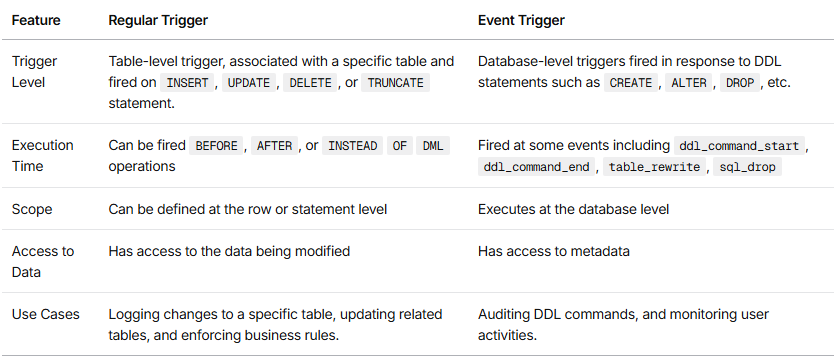
